# Pipeline to run metacell in Breast cellxgene dataset

conda environment: cellxgene

In [44]:

import anndata as ad             # For reading/writing AnnData files
import matplotlib.pyplot as plt  # For plotting
import metacells as mc           # The Metacells package
import numpy as np               # For array/matrix operations
import pandas as pd              # For data frames
import os                        # For filesystem operations
import seaborn as sb             # For plotting
import scipy.sparse as sp        # For sparse matrices
import shutil                    # for filesystem operations
from math import hypot           # For plotting

## 1. Loading anndata object

In [45]:
full = ad.read_h5ad("/mnt/scratch1/Fcarcanholo/cellxgene_python/cellxgene_BRCA_2M.h5ad")
full = full[np.random.choice(full.n_obs, 300000, replace=False)] #making a sample of 300k cells to fast test

### Converting ENSEMBL to SYMBOL

In [46]:
import pandas as pd
import mygene

# Create an instance of MyGeneInfo
mg = mygene.MyGeneInfo()
# Example list of ENSEMBL IDs
ensembl_ids = full.var.index
# Query MyGene.info for gene symbols
# The query can handle a large list of IDs at once
results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')
# Convert results into a DataFrame for easier handling
result_df = pd.DataFrame(results)
# Filter out any entries that did not return a symbol
result_df = result_df[['query', 'symbol']].dropna()
# Rename columns for clarity
result_df.columns = ['Ensembl_ID', 'Gene_Symbol']
result_df = result_df[result_df['Gene_Symbol'].duplicated(keep=False) == False]
id_to_symbol = dict(zip(result_df['Ensembl_ID'], result_df['Gene_Symbol']))
full = full[:,(result_df['Ensembl_ID'].tolist())] #leaving just the genes that has a convertion to gene symbol, without converting yet
# Update the var index using the dictionary and filter out missing genes
full.var["gene_ids"] = full.var.index
full.var.index = full.var.index.map(id_to_symbol)
full.var_names_make_unique()
full.raw.var.index = full.raw.var.index.map(id_to_symbol)
full.raw.var.index = full.raw.var.index.astype(str)

1 input query terms found dup hits:	[('ENSG00000227110', 2)]
15 input query terms found no hit:	['ENSG00000237975', 'ENSG00000239332', 'ENSG00000223797', 'ENSG00000240875', 'ENSG00000270604', 'ENS
/tmp/ipykernel_2538805/922074254.py:21: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  full.var["gene_ids"] = full.var.index
/home/fcarcanh/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/fcarcanh/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [47]:
mc.ut.top_level(full)
mc.ut.set_name(full, "Breast_2M.full")

## 2. Cleaning the data

### 2.1 Excluding doublets

Assuming is already excluded in QC

### 2.2 Decisions

Cleaning up the data (whether in pre-processing or using the steps below) requires us to make decisions, based on prior biological knowledge and experience with the pipeline. Also, none of the decisions is final. In real analysis, we often iterate the analysis, revisiting and refining prior decisions, until we obtain a "good" final result. Here in the one-pass vignette, we assume we get things right the first time around.

#### 2.2.1 Excluding cells by UMIs count

The first decision we need to make is "how many UMIs can a clean cell contain".
Cells with "too few" UMIs indicate very low-quality sampling and might be just empty droplets.
Cells with "too many" UMIs might be doublets.
The thresholds to use depends on the technology and the dataset, and the specifics of any pre-processing done, if any. The method we use here is to look at the distribution of total UMIs per cell,
and pick "reasonable" thresholds for exclusions based on it.

In [48]:
PROPERLY_SAMPLED_MIN_CELL_TOTAL = 800
PROPERLY_SAMPLED_MAX_CELL_TOTAL = 20000

Will exclude 86 (0.03%%) cells with less than 800 UMIs
Will exclude 0 (0.00%%) cells with more than 20000 UMIs


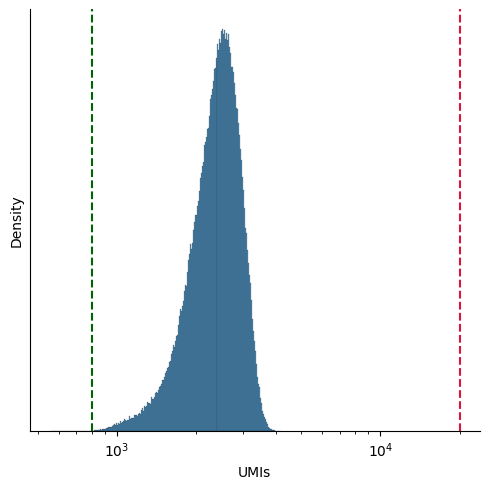

In [49]:
total_umis_per_cell = mc.ut.get_o_numpy(full, "__x__", sum=True)
plot = sb.displot(total_umis_per_cell, log_scale=(10, None))
plot.set(xlabel="UMIs", ylabel="Density", yticks=[])

plot.refline(x=PROPERLY_SAMPLED_MIN_CELL_TOTAL, color="darkgreen")
plot.refline(x=PROPERLY_SAMPLED_MAX_CELL_TOTAL, color="crimson")


too_small_cells_count = np.sum(total_umis_per_cell < PROPERLY_SAMPLED_MIN_CELL_TOTAL)
too_large_cells_count = np.sum(total_umis_per_cell > PROPERLY_SAMPLED_MAX_CELL_TOTAL)

total_umis_per_cell = mc.ut.get_o_numpy(full, name="__x__", sum=True)
too_small_cells_percent = 100.0 * too_small_cells_count / full.n_obs
too_large_cells_percent = 100.0 * too_large_cells_count / full.n_obs

print(
    f"Will exclude {too_small_cells_count} ({too_small_cells_percent:.2f}%%) cells"
    f" with less than {PROPERLY_SAMPLED_MIN_CELL_TOTAL} UMIs"
)
print(
    f"Will exclude {too_large_cells_count} ({too_large_cells_percent:.2f}%%) cells"
    f" with more than {PROPERLY_SAMPLED_MAX_CELL_TOTAL} UMIs"
)

#### 2.2.2 Excluding genes by name

The next decision we need to make is which genes to exclude from the data, by their names.
The poster children for this are mytochondrial genes and strong sex-specific genes. Here we also exclude the non-coding `NEAT1` gene.

In the iterative process, we may discover additional genes to exclude later on. Here in the one-pass vignette, we assume we have the right list from the start. Realistically, one would start with a list that was used for similar data in the past, and possibly tweak it later as needed.

In [50]:
EXCLUDED_GENE_NAMES = [
    "XIST", "MALAT1",   # Sex-specific genes.
    "NEAT1"             # Non-coding.
]
EXCLUDED_GENE_PATTERNS = ["MT-.*"]  # Mytochondrial.

We'll instruct the package to exclude the genes we have chosen.
By default, the code will also automatically exclude a few additional genes,
specifically genes with very high variance that are not correlated with any other gene (`bursty_lonely_gene`, see the documentation for details).
Such genes are useless for grouping cells together;
even worse, including them is actively harmful as they cause cells to appear to be deviants
(have a gene in which they are very different from the rest of the cells in the same metacell),
and thereby be marked as outliers.

Converting .X to dense array so i can change it

In [51]:
if hasattr(full.X, 'toarray'):
    cells_dense = full.X.toarray()  # Convert to dense array
else:
    cells_dense = full.X
full.X = cells_dense

In [52]:
mc.pl.exclude_genes(
    full,
    excluded_gene_names=EXCLUDED_GENE_NAMES, 
    excluded_gene_patterns=EXCLUDED_GENE_PATTERNS,
    random_seed=123456,
)

set Breast_2M.full.var[bursty_lonely_gene]: 0 true (0%) out of 15151 bools
set Breast_2M.full.var[properly_sampled_gene]: 15151 true (100%) out of 15151 bools
set Breast_2M.full.var[excluded_gene]: 3 true (0.0198%) out of 15151 bools


#### 2.2.3 Excluding cells by high excluded gene UMIs

The next decision we need to make is which cells to exclude due to
containing too many UMIs in the excluded genes.
If a cell contains "too many" excluded (mainly mytochondrial) gene UMIs,
this may indicate a badly sampled cell, leading to very skewed results.
Again, the exact threshold depends on both the technology and the dataset.
Here we resort to looking at the distribution of the fraction of excluded genes in each cell,
and manually picking the threshold.

We start by computing the total UMIs of excluded genes in each cell.
We only need to do this once (as long as we don't change the list of excluded genes).

In [53]:
mc.tl.compute_excluded_gene_umis(full)

set Breast_2M.full.obs[excluded_umis]: 300000 float32s


Next we'll pick a maximal fraction of excluded UMIs in each cell.

In [54]:
PROPERLY_SAMPLED_MAX_EXCLUDED_GENES_FRACTION = 0.25 #defaut

We can visualize the cell excluded genes fraction threshold decision and adjust it accordingly:

Will exclude 0 (0.00%) cells with more than 25.00% excluded gene UMIs


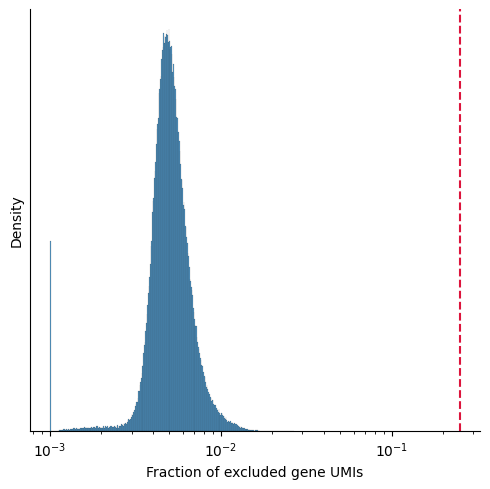

In [55]:
excluded_umis_fraction_regularization = 1e-3  # Avoid 0 values in log scale plot.
excluded_umis_per_cell = mc.ut.get_o_numpy(full, "excluded_umis")
excluded_umis_fraction_per_cell = excluded_umis_per_cell / total_umis_per_cell

excluded_umis_fraction_per_cell += excluded_umis_fraction_regularization
plot = sb.displot(excluded_umis_fraction_per_cell, log_scale=(10, None))
excluded_umis_fraction_per_cell -= excluded_umis_fraction_regularization

plot.set(xlabel="Fraction of excluded gene UMIs", ylabel="Density", yticks=[])
plot.refline(x=PROPERLY_SAMPLED_MAX_EXCLUDED_GENES_FRACTION, color="crimson")

too_excluded_cells_count = np.sum(
    excluded_umis_fraction_per_cell > PROPERLY_SAMPLED_MAX_EXCLUDED_GENES_FRACTION
)
too_excluded_cells_fraction = too_excluded_cells_count / full.n_obs

print(
    f"Will exclude {too_excluded_cells_count} ({100 * too_excluded_cells_fraction:.2f}%) cells"
    f" with more than {100 * PROPERLY_SAMPLED_MAX_EXCLUDED_GENES_FRACTION:.2f}% excluded gene UMIs"
)

Now excluding the cells

In [56]:
mc.pl.exclude_cells(
    full,
    properly_sampled_min_cell_total=PROPERLY_SAMPLED_MIN_CELL_TOTAL,
    properly_sampled_max_cell_total=PROPERLY_SAMPLED_MAX_CELL_TOTAL,
    properly_sampled_max_excluded_genes_fraction=PROPERLY_SAMPLED_MAX_EXCLUDED_GENES_FRACTION,
    #additional_cells_masks=["|doublet_cell"]
)

set Breast_2M.full.obs[properly_sampled_cell]: 299914 true (99.97%) out of 300000 bools
set Breast_2M.full.obs[excluded_cell]: 86 true (0.02867%) out of 300000 bools


### 2.3 Extract the clean data

In [57]:
clean = mc.pl.extract_clean_data(full, name="immune_2M.one-pass.clean")
mc.ut.top_level(clean)

set immune_2M.one-pass.clean.obs[full_cell_index]: 299914 int32s
set immune_2M.one-pass.clean.var[full_gene_index]: 15148 int32s


## 3. Saving data

Saving data before computting the metacells

In [58]:
full.write_h5ad("/mnt/scratch1/Fcarcanholo/cellxgene_python/metacell_git/metacells-vignettes/output/one-pass/preliminary/hca_bm.full.h5ad")
clean.write_h5ad("/mnt/scratch1/Fcarcanholo/cellxgene_python/metacell_git/metacells-vignettes/output/one-pass/preliminary/hca_bm.clean.h5ad")

## 4. Compute the metacells

In [59]:
cells = ad.read_h5ad("/mnt/scratch1/Fcarcanholo/cellxgene_python/metacell_git/metacells-vignettes/output/one-pass/preliminary/hca_bm.clean.h5ad")
mc.ut.set_name(cells, "immune_2M.one-pass.preliminary.cells")

### 4.1 Decisions

Even though we have the clean cells data, we can't compute metacells for it before making a few more decisions.

#### 4.1.1 Lateral genes

A crucial decision when running metacells is the list of genes are lateral,
that is, should **not** be used to group cells together.
The poster child for this are cell-cycle genes.
These genes are strong and any clustering algorithm will therefore prefer to group together cells in the same cell-cycle state,
at the expense of mixing up other (reasonably close) cell states,
which are what we are actually interested in.
Note that lateral genes are still used in deviant cell detection,
that is, each lateral gene should still have a consistent expression level in all the cells in each metacell.

In the iterative process, we start with a very short list of genes we have a strong a-priori opinion about, expand it, and then iteratively add more genes until we settle on the final list. Here in the one-pass vignette, we assume we have the right list from the start. Realistically, one could start with a list that was used for similar data in the past, and possibly tweak it later as needed.

In [60]:
LATERAL_GENE_NAMES = [
    "ACSM3", "ANP32B", "APOE", "AURKA", "B2M", "BIRC5", "BTG2", "CALM1", "CD63", "CD69", "CDK4",
    "CENPF", "CENPU", "CENPW", "CH17-373J23.1", "CKS1B", "CKS2", "COX4I1", "CXCR4", "DNAJB1",
    "DONSON", "DUSP1", "DUT", "EEF1A1", "EEF1B2", "EIF3E", "EMP3", "FKBP4", "FOS", "FOSB", "FTH1",
    "G0S2", "GGH", "GLTSCR2", "GMNN", "GNB2L1", "GPR183", "H2AFZ", "H3F3B", "HBM", "HIST1H1C",
    "HIST1H2AC", "HIST1H2BG", "HIST1H4C", "HLA-A", "HLA-B", "HLA-C", "HLA-DMA", "HLA-DMB",
    "HLA-DPA1", "HLA-DPB1", "HLA-DQA1", "HLA-DQB1", "HLA-DRA", "HLA-DRB1", "HLA-E", "HLA-F", "HMGA1",
    "HMGB1", "HMGB2", "HMGB3", "HMGN2", "HNRNPAB", "HSP90AA1", "HSP90AB1", "HSPA1A", "HSPA1B",
    "HSPA6", "HSPD1", "HSPE1", "HSPH1", "ID2", "IER2", "IGHA1", "IGHA2", "IGHD", "IGHG1", "IGHG2",
    "IGHG3", "IGHG4", "IGHM", "IGKC", "IGKV1-12", "IGKV1-39", "IGKV1-5", "IGKV3-15", "IGKV4-1",
    "IGLC2", "IGLC3", "IGLC6", "IGLC7", "IGLL1", "IGLL5", "IGLV2-34", "JUN", "JUNB", "KIAA0101",
    "LEPROTL1", "LGALS1", "LINC01206", "LTB", "MCM3", "MCM4", "MCM7", "MKI67", "MT2A", "MYL12A",
    "MYL6", "NASP", "NFKBIA", "NUSAP1", "PA2G4", "PCNA", "PDLIM1", "PLK3", "PPP1R15A", "PTMA",
    "PTTG1", "RAN", "RANBP1", "RGCC", "RGS1", "RGS2", "RGS3", "RP11-1143G9.4", "RP11-160E2.6",
    "RP11-53B5.1", "RP11-620J15.3", "RP5-1025A1.3", "RP5-1171I10.5", "RPS10", "RPS10-NUDT3", "RPS11",
    "RPS12", "RPS13", "RPS14", "RPS15", "RPS15A", "RPS16", "RPS17", "RPS18", "RPS19", "RPS19BP1",
    "RPS2", "RPS20", "RPS21", "RPS23", "RPS24", "RPS25", "RPS26", "RPS27", "RPS27A", "RPS27L",
    "RPS28", "RPS29", "RPS3", "RPS3A", "RPS4X", "RPS4Y1", "RPS4Y2", "RPS5", "RPS6", "RPS6KA1",
    "RPS6KA2", "RPS6KA2-AS1", "RPS6KA3", "RPS6KA4", "RPS6KA5", "RPS6KA6", "RPS6KB1", "RPS6KB2",
    "RPS6KC1", "RPS6KL1", "RPS7", "RPS8", "RPS9", "RPSA", "RRM2", "SMC4", "SRGN", "SRSF7", "STMN1",
    "TK1", "TMSB4X", "TOP2A", "TPX2", "TSC22D3", "TUBA1A", "TUBA1B", "TUBB", "TUBB4B", "TXN", "TYMS",
    "UBA52", "UBC", "UBE2C", "UHRF1", "YBX1", "YPEL5", "ZFP36", "ZWINT"
]
LATERAL_GENE_PATTERNS = ["RP[LS].*"]  # Ribosomal

In [61]:
# This will mark as "lateral_gene" any genes that match the above, if they exist in the clean dataset.
mc.pl.mark_lateral_genes(
    cells,
    lateral_gene_names=LATERAL_GENE_NAMES,
    lateral_gene_patterns=LATERAL_GENE_PATTERNS,
)

lateral_gene_mask = mc.ut.get_v_numpy(cells, "lateral_gene")
lateral_gene_names = set(cells.var_names[lateral_gene_mask])
print(sorted([
    name for name in lateral_gene_names
    if not name.startswith("RPL") and not name.startswith("RPS")
]))
print(f"""and {len([
    name for name in lateral_gene_names if name.startswith("RPL") or name.startswith("RPS")
])} RP[LS].* genes""")

set immune_2M.one-pass.preliminary.cells.var[lateral_gene]: 211 true (1.393%) out of 15148 bools


['ACSM3', 'ANP32B', 'APOE', 'AURKA', 'B2M', 'BIRC5', 'BTG2', 'CALM1', 'CD63', 'CD69', 'CDK4', 'CENPF', 'CENPU', 'CENPW', 'CKS1B', 'CKS2', 'COX4I1', 'CXCR4', 'DNAJB1', 'DONSON', 'DUSP1', 'DUT', 'EEF1A1', 'EEF1B2', 'EIF3E', 'EMP3', 'FKBP4', 'FOS', 'FOSB', 'FTH1', 'G0S2', 'GGH', 'GMNN', 'GPR183', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRA', 'HLA-DRB1', 'HLA-E', 'HLA-F', 'HMGA1', 'HMGB1', 'HMGB2', 'HMGB3', 'HMGN2', 'HNRNPAB', 'HSP90AA1', 'HSP90AB1', 'HSPA1A', 'HSPA1B', 'HSPA6', 'HSPD1', 'HSPE1', 'HSPH1', 'ID2', 'IER2', 'IGLL1', 'JUN', 'JUNB', 'LEPROTL1', 'LGALS1', 'LTB', 'MCM3', 'MCM4', 'MCM7', 'MKI67', 'MT2A', 'MYL12A', 'MYL6', 'NASP', 'NFKBIA', 'NUSAP1', 'PA2G4', 'PCNA', 'PDLIM1', 'PLK3', 'PPP1R15A', 'PTMA', 'PTTG1', 'RAN', 'RANBP1', 'RGCC', 'RGS1', 'RGS2', 'RGS3', 'RRM2', 'SMC4', 'SRGN', 'SRSF7', 'STMN1', 'TK1', 'TMSB4X', 'TOP2A', 'TPX2', 'TSC22D3', 'TUBA1A', 'TUBA1B', 'TUBB', 'TUBB4B', 'TXN', 'TYMS', 'UBA52', 'UBC', 'UBE2C'

#### 4.1.2 Noisy genes

Another important list of genes are the genes with higher than usual variance,
which will cause a lot of cells to be deviant (inconsistent with their metacells),
and therefore be marked as deviants (outliers). Marking them as "noisy" allows for more variance for these genes in each metacell, reducing the number of such outliers.

In the iterative process, we typically start with an empty list of genes, and then iteratively add more genes until we settle on the final list. Here in the one-pass vignette, we assume we have the right list from the start. Realistically, one could start with a list that was used for similar data in the past, and possiblly tweak it later as needed.

In [62]:
NOISY_GENE_NAMES = [
    "CCL3", "CCL4", "CCL5", "CXCL8", "DUSP1", "FOS", "G0S2", "HBB", "HIST1H4C", "IER2", "IGKC",
    "IGLC2", "JUN", "JUNB", "KLRB1", "MT2A", "RPS26", "RPS4Y1", "TRBC1", "TUBA1B", "TUBB"
]

In [63]:
# This will mark as "noisy_gene" any genes that match the above, if they exist in the clean dataset.
mc.pl.mark_noisy_genes(cells, noisy_gene_names=NOISY_GENE_NAMES)

set immune_2M.one-pass.preliminary.cells.var[noisy_gene]: 15 true (0.09902%) out of 15148 bools


#### 4.1.3 Parallelization

Finally, we need to decide on how much parallelization to use.
This is a purely technical decision - it does not affect the results, just the performance.

The more parallel piles we use, the faster the computation will be
(up to the number of physical processors, but that is handled automatically for us).

However, having more parallel piles means using more memory.
If we run out of memory, we'll need to reduce the number of parallel piles.
You can track the memory usage by running `top` or `htop` during the computation.

We provide a guesstimator for the maximal number of parallel piles that will fit in memory.
This is by no means perfect, but it is a starting point.

In [64]:
# Either use the guesstimator:
max_parallel_piles = mc.pl.guess_max_parallel_piles(cells)
# Or, if running out of memory manually override:
# max_paralle_piles = ...
print(max_parallel_piles)
mc.pl.set_max_parallel_piles(max_parallel_piles)

681


### 4.2 Computation

We are (*finally*) ready to actually group the cells into metacells.

#### 4.2.1 Hyper-parameters

The metacells pipeline has a *lot* of hyper parameters you can tweak. The defaults were chosen such that scRNA-seq data, especially 10x data, should work "well" out of the box. You should read the documentation and have a good understanding of the effect of anny parameter you may want to tweak, keeping in mind the synergy between some of the parameters.

If we had to call out one hyper-parameter you *might* wish to tweak, it would be the `target_metacell_size`. This specifies the "ideal" number of cells in each metacell. The algorithm works hard to keep the actual metacell size close to this value - in particular, metacells larger than twice this size will be split, and metacells which are much smaller than this size will be merged, or dissolved (become outliers).

By default this value is set to `96`. Setting it to a smaller value will create more metacells, which may allow capturing more subtle differences between cell states (e.g. along a gradient); this, however, would come at the cost of making less robust estimations of each gene's expression level in each metacell. This *might* be a worthwhile tradeoff if your cells are of higher quality.

One technical "hyper-paramater" you *must* specify is the `random_seed`. A non-zero value will genenrate reproducible results. A zero value will generate non-reproducible results and will be *slightly* faster. We "strongly urge" you to use a non-zero as reproducible results are *much* easier to deal with.

#### 4.2.2 Assigning cells to metacells

This is the core of the method.
It can take a while.
The dataset used in this example is far from trivial - it contains ~1/3M cells.
This takes ~10 minutes to compute on a hefty (48 HT cores, 0.5TB RAM) server.
You can see progress is being made by running the computation with a progress bar.
This progress is rather non-linear,
for example there's a pause at the start when computing rare gene modules,
and it isn't smooth afterwards either.
You can skip it alltogether by getting rid of the `with` statement.

In [ ]:
with mc.ut.progress_bar():
    mc.pl.divide_and_conquer_pipeline(cells, random_seed=123456)

Detect rare gene modules...
100%|█████████▉[04:16]


#### 4.2.3 Collecting the metacells

The above merely computed a metacell name and index for each cell ("Outliers" and negative for outlier cells). We still need to collect all the cells of each metacell, to create a new `AnnData` where each profile is a metacell. Note that in this new metacells data, we no longer have UMIs per gene; instead, for each gene, we have an estimate of the fraction of its UMIs out of the total UMIs. Since `AnnData` can only hold a single 2D dataset, the result must be a separate object (with each "observation" being a metacell), so we copy all the per-gene annotations from the cells dataset to the result.

In [ ]:
metacells = \
    mc.pl.collect_metacells(cells, name="immune_2M.one-pass.preliminary.metacells", random_seed=123456)
print(f"Preliminary: {metacells.n_obs} metacells, {metacells.n_vars} genes")

transposing metadata for metacell

In [ ]:
# Getting metadata from single cell into metacell metadata
mc.tl.convey_obs_to_group(
    adata=cells, gdata=metacells,
    property_name="cell_type", to_property_name="cell_type",
    method=mc.ut.most_frequent  # This is the default, for categorical data
)
mc.tl.convey_obs_to_group(
    adata=cells, gdata=metacells,
    property_name="disease", to_property_name="disease",
    method=mc.ut.most_frequent
)

Compute for mcview

In [ ]:
with mc.ut.progress_bar():
    mc.pl.compute_for_mcview(adata=cells, gdata=metacells, random_seed=123456)

In [ ]:
min_long_edge_size = 4
umap_x = mc.ut.get_o_numpy(metacells, "x")
umap_y = mc.ut.get_o_numpy(metacells, "y")
umap_edges = sp.coo_matrix(mc.ut.get_oo_proper(metacells, "obs_outgoing_weights"))
sb.set()
plot = sb.scatterplot(x=umap_x, y=umap_y, s=10)
for (
    source_index, target_index, weight
) in zip(
    umap_edges.row, umap_edges.col, umap_edges.data
):
    source_x = umap_x[source_index]
    target_x = umap_x[target_index]
    source_y = umap_y[source_index]
    target_y = umap_y[target_index]
    if hypot(target_x - source_x, target_y - source_y) >= min_long_edge_size:
        plt.plot([source_x, target_x], [source_y, target_y],
                 linewidth=weight * 2, color='indigo')
plt.show()

In [ ]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming 'metacells' is your AnnData object and it has been processed
umap_x = mc.ut.get_o_numpy(metacells, "x")
umap_y = mc.ut.get_o_numpy(metacells, "y")
umap_edges = sp.coo_matrix(mc.ut.get_oo_proper(metacells, "obs_outgoing_weights"))

# Extract cell types from the AnnData object
cell_types = metacells.obs['cell_type']

# Create a color palette for the unique cell types
unique_cell_types = cell_types.unique()
colors = sb.color_palette("hsv", len(unique_cell_types))  # You can choose other palettes

# Create a mapping from cell type to color
color_map = dict(zip(unique_cell_types, colors))

# Map colors to each cell based on their type
cell_colors = cell_types.map(color_map)

# Set up the plot
sb.set()
plt.figure(figsize=(10, 8))
plot = sb.scatterplot(x=umap_x, y=umap_y, s=10, hue=cell_types, palette=color_map)

# Draw edges based on outgoing weights
for source_index, target_index, weight in zip(umap_edges.row, umap_edges.col, umap_edges.data):
    source_x = umap_x[source_index]
    target_x = umap_x[target_index]
    source_y = umap_y[source_index]
    target_y = umap_y[target_index]
    if hypot(target_x - source_x, target_y - source_y) >= min_long_edge_size:
        plt.plot([source_x, target_x], [source_y, target_y],
                 linewidth=weight * 2, color='indigo')

# Add legend and labels
plt.title("UMAP Plot Colored by Cell Type")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Getting the MostCellType dataframe with annotation in "cell" dataset

In [ ]:
cells_meta = cells.obs
cells_meta = cells_meta[["cell_type", "metacell_name"]]
counts = cells_meta.groupby(["metacell_name", "cell_type"]).size()
most_cell_type = counts.unstack(fill_value=0)
most_cell_type['total_cells'] = most_cell_type.sum(axis=1)
#getting the % of cells
normalized_counts = most_cell_type.drop(columns='total_cells')
normalized_counts = normalized_counts.div(most_cell_type['total_cells'], axis=0)
most_cell_type[normalized_counts.columns] = normalized_counts

Save most cell type in csv

In [ ]:
most_cell_type.to_csv("/mnt/scratch1/Fcarcanholo/cellxgene_python/metacell_git/most_cell_type.csv")

Passing the most_cell_type summary information into metacell anndata as 2 new columns

In [ ]:
metacells.obs["porct_cell_type"] = None
metacells.obs["total_cells"] = None
for line in range(len(metacells.obs)):
    cell_type = metacells.obs["cell_type"].iloc[line]
    metacell_name = metacells.obs.index[line]
    metacells.obs["porct_cell_type"].iloc[line] = most_cell_type.loc[metacell_name, cell_type]
    metacells.obs["total_cells"].iloc[line] = most_cell_type["total_cells"].loc[metacell_name]

Seeing the distribution of porcentage of cells types within metacells

In [ ]:
import matplotlib.pyplot as plt

metacells.obs["porct_cell_type"].plot(kind='hist', bins=100)
plt.title("histogram of porcentage of cells within metacells")
plt.xlabel('Value')
plt.ylabel('Frequency')
#plt.legend(title='Columns')
plt.show()

Seeing the distribution of quantity of cells used to build metacells

In [ ]:
metacells.obs["total_cells"].plot(kind='hist', bins=100)
plt.title("histogram of quantity of cells used to build metacells")
plt.xlabel('Value')
plt.ylabel('Frequency')
#plt.legend(title='Columns')
plt.show()

## Filtering to have just metacells with more than 95% of same cell type

In [ ]:
metacell_output = metacells
metacell_output = metacell_output[metacell_output.obs['porct_cell_type'] > 0.95] #0.95 has 2680 metacels, 0.90 3823

In [ ]:
if 'porct_cell_type' in metacell_output.obs.columns:
    metacell_output.obs['porct_cell_type'] = metacell_output.obs['porct_cell_type'].astype(str)
metacell_output.obs['porct_cell_type'] = metacell_output.obs['porct_cell_type'].fillna("NaN").astype(str)
if 'total_cells' in metacell_output.obs.columns:
    metacell_output.obs['total_cells'] = metacell_output.obs['total_cells'].astype(str)
metacell_output.obs['total_cells'] = metacell_output.obs['total_cells'].fillna("NaN").astype(str)

Saving

In [ ]:
metacell_output.write_h5ad("/mnt/scratch1/Fcarcanholo/cellxgene_python/metacell_git/metacell_output.filtred_BRCA.h5ad")
